In [23]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from sklearn.exceptions import ConvergenceWarning
from sklearn import model_selection, preprocessing, metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
import time
import xgboost as xgb
import csv
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [24]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')

In [35]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (4209, 378)
test_df.shape (4209, 377)


In [36]:
filter_outliers = True
xgb_use_augment_features = True
add_magic_feature = True

if filter_outliers:
    print('Filtering outliers')
    # Filter out outlier y = 265.32
    train_df = train_df[train_df.y < 200]

# Preprocess data
print('Dropping constant value columns')
for column in train_df.columns:
    cardinality = len(np.unique(train_df[column]))
    if cardinality == 1:
        train_df.drop(column, axis=1, inplace=True)
        test_df.drop(column, axis=1, inplace=True)

original_train_columns = sorted(list(set(train_df.columns) - set(['ID', 'y'])))
        
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
    lbl = preprocessing.LabelEncoder()
    train_values = set(train_df[f].values)
    test_values = set(test_df[f].values)
    all_values = list(train_values | test_values)
    lbl.fit(all_values) 
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))

if xgb_use_augment_features:
    n_comp = 10
    
    # PCA
    pca = PCA(n_components=n_comp, random_state=420)
    pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
    pca2_results_test = pca.transform(test_df)

    # ICA
    ica = FastICA(n_components=n_comp, random_state=420)
    ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
    ica2_results_test = ica.transform(test_df)

    # GRP
    grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
    grp_results_train = grp.fit_transform(train_df.drop(["y"], axis=1))
    grp_results_test = grp.transform(test_df)

    # SRP
    srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
    srp_results_train = srp.fit_transform(train_df.drop(["y"], axis=1))
    srp_results_test = srp.transform(test_df)
    
    # Append decomposition components to datasets
    for i in range(0, n_comp):
        train_df['pca_' + str(i)] = pca2_results_train[:, i]
        test_df['pca_' + str(i)] = pca2_results_test[:, i]

        train_df['ica_' + str(i)] = ica2_results_train[:, i]
        test_df['ica_' + str(i)] = ica2_results_test[:, i]
        
        train_df['grp_' + str(i)] = grp_results_train[:, i]
        test_df['grp_' + str(i)] = grp_results_test[:, i]
        
        train_df['srp_' + str(i)] = srp_results_train[:, i]
        test_df['srp_' + str(i)] = srp_results_test[:, i]
        
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

Filtering outliers
Dropping constant value columns
train_df.shape (4208, 406)
test_df.shape (4209, 405)


In [37]:
X = train_df.drop(["ID", "y"], axis=1)
Y = train_df['y'].values
test_X = test_df.drop(["ID"], axis=1)

train_X, holdout_X, train_Y, holdout_Y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=29)
print('X.shape', X.shape)
print('Y.shape', Y.shape)
print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('holdout_X.shape', holdout_X.shape)
print('holdout_Y.shape', holdout_Y.shape)
print('test_X.shape', test_X.shape)

if add_magic_feature:
    temp_X = train_X.copy()
    temp_X['y'] = train_Y
    median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
    holdout_X_median_df = pd.merge(holdout_X, median_df, on='X0', how='left')
    holdout_X_median_df.loc[holdout_X_median_df.median_y.isnull(), 'median_y'] = train_Y.mean()
    holdout_X = holdout_X_median_df
    print('holdout_X.shape', holdout_X.shape)
    
    temp_X = X.copy()
    temp_X['y'] = Y
    median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
    test_X_median_df = pd.merge(test_X, median_df, on='X0', how='left')
    test_X_median_df.loc[test_X_median_df.median_y.isnull(), 'median_y'] = Y.mean()
    test_X = test_X_median_df
    print('test_X.shape', test_X.shape)

X.shape (4208, 404)
Y.shape (4208,)
train_X.shape (3366, 404)
train_Y.shape (3366,)
holdout_X.shape (842, 404)
holdout_Y.shape (842,)
test_X.shape (4209, 404)
holdout_X.shape (842, 405)
test_X.shape (4209, 405)


In [63]:
NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

for fold, (train_idxs, val_idxs) in enumerate(kf.split(train_X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = train_X.iloc[train_idxs], train_X.iloc[val_idxs]
    trn_Y, val_Y = train_Y[train_idxs], train_Y[val_idxs]
    
    mean_Y = trn_Y.mean()
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df
        
    def xgb_r2_score(preds, dtrain):
        labels = dtrain.get_label()
        return 'rmse', -1.0 * metrics.r2_score(labels, preds)

    model = xgb.XGBRegressor(max_depth = 5,
                        #gamma=0.5,
                        objective="reg:linear",
                        n_estimators=1500,
                        learning_rate=0.0045,
                        nthread=12,
                        subsample=0.93,
                        #colsample_bytree=0.70,
                        #colsample_bylevel=0.70,
                        base_score=mean_Y,
                        seed=42,
                        silent=True)

    model.fit(trn_X, trn_Y, eval_set=[(trn_X, trn_Y), (val_X, val_Y)], verbose=False, eval_metric='rmse', early_stopping_rounds=50)
    evals_result = model.evals_result()
    pickle.dump(model, open(os.path.join(MODELS_PATH, model_id + ".xgb"), "wb"))
    
    trn_Y_pred = model.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    train_var = np.var(trn_Y_pred)
    train_mae = metrics.mean_absolute_error(trn_Y, trn_Y_pred)
    
    val_Y_pred = model.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    val_var = np.var(val_Y_pred)
    val_mae = metrics.mean_absolute_error(val_Y, val_Y_pred)
    
    holdout_Y_pred = model.predict(holdout_X)
    holdout_r2_score = metrics.r2_score(holdout_Y, holdout_Y_pred)
    holdout_var = np.var(holdout_Y_pred)
    holdout_mae = metrics.mean_absolute_error(holdout_Y, holdout_Y_pred)
    
    perf.append((fold, model_id, train_r2_score, val_r2_score, holdout_r2_score,
                 train_var, val_var, holdout_var,
                 train_mae, val_mae, holdout_mae))

perf_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2', 'holdout_r2',
                                      'train_var', 'validation_var', 'holdout_var',
                                      'train_mae', 'validation_mae', 'holdout_mae'])
print('avg train r2', perf_df['train_r2'].mean(),
      'avg validation r2', perf_df['validation_r2'].mean(), 
      'avg holdout r2', perf_df['holdout_r2'].mean(),
      'avg train var', perf_df['train_var'].mean(),
      'avg validation var', perf_df['validation_var'].mean(),
      'avg holdout var', perf_df['holdout_var'].mean(),
      'avg train mae', perf_df['train_mae'].mean(),
      'avg validation mae', perf_df['validation_mae'].mean(),
      'avg holdout mae', perf_df['holdout_mae'].mean())
perf_df

Fold 0 Training model-1498405918
Fold 1 Training model-1498405921
Fold 2 Training model-1498405923
Fold 3 Training model-1498405926
Fold 4 Training model-1498405928
avg train r2 0.717526687365 avg validation r2 0.579376168017 avg holdout r2 0.567963532217 avg train var 85.9709915161 avg validation var 82.9184692383 avg holdout var 79.8925201416 avg train mae 4.51624848163 avg validation mae 5.29882210662 avg holdout mae 5.45776487852


,fold,model_id,train_r2,validation_r2,holdout_r2,train_var,validation_var,holdout_var,train_mae,validation_mae,holdout_mae
0,0,model-1498405918,0.717698,0.586821,0.564627,87.290451,78.852570,79.842918,4.517575,5.382906,5.479532
1,1,model-1498405921,0.690827,0.654811,0.572151,84.133659,85.806854,80.149033,4.758672,4.895639,5.426865
2,2,model-1498405923,0.709223,0.531947,0.567178,81.812096,82.876976,76.547119,4.535726,5.565391,5.511908
3,3,model-1498405926,0.715064,0.505020,0.563906,84.453384,79.051277,78.063713,4.556055,5.568887,5.466460
4,4,model-1498405928,0.754822,0.618281,0.571955,92.165367,88.004669,84.859818,4.213215,5.081287,5.404060


In [64]:
# Avg xgb models predictions
VALIDATION_THRESHOLD = 0.4
NUM_MODELS = perf_df[perf_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

count = 0
for row in perf_df.itertuples():
    fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
    if validation_r2 < VALIDATION_THRESHOLD:
        continue
    model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.xgb'), 'rb'))
    test_Y_pred[:, count] = model.predict(test_X)
    holdout_Y_pred[:, count] = model.predict(holdout_X)
    count += 1

holdout_Y_avg = np.mean(holdout_Y_pred, axis=1)
test_Y_avg = np.mean(test_Y_pred, axis=1)
test_Y_avg.shape

(4209,)

In [40]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

for fold, (train_idxs, val_idxs) in enumerate(kf.split(train_X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = train_X.iloc[train_idxs], train_X.iloc[val_idxs]
    trn_Y, val_Y = train_Y[train_idxs], train_Y[val_idxs]
    
    if add_magic_feature:
        temp_X = trn_X.copy()
        temp_X['y'] = trn_Y
        median_df = temp_X.groupby('X0').y.mean().reset_index().rename(columns={'y':'median_y'})
        trn_X_median_df = pd.merge(trn_X, median_df, on='X0', how='left')
        trn_X = trn_X_median_df
        
        val_X_median_df = pd.merge(val_X, median_df, on='X0', how='left')
        val_X_median_df.loc[val_X_median_df.median_y.isnull(), 'median_y'] = trn_Y.mean()
        val_X = val_X_median_df
    
    stacked_pipeline = make_pipeline(
        StackingEstimator(estimator=LassoLarsCV(normalize=True)),
        StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber",
                                                              n_estimators=500, max_depth=3,
                                                              max_features=0.55, min_samples_leaf=18,
                                                              min_samples_split=14, subsample=0.7)),
        LassoLarsCV())
    stacked_pipeline.fit(trn_X, trn_Y)
    pickle.dump(stacked_pipeline, open(os.path.join(MODELS_PATH, model_id + ".stacked"), "wb"))
   
    trn_Y_pred = stacked_pipeline.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    train_var = np.var(trn_Y_pred)
    train_mae = metrics.mean_absolute_error(trn_Y, trn_Y_pred)
    
    val_Y_pred = stacked_pipeline.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    val_var = np.var(val_Y_pred)
    val_mae = metrics.mean_absolute_error(val_Y, val_Y_pred)
    
    holdout_Y_pred = stacked_pipeline.predict(holdout_X)
    holdout_r2_score = metrics.r2_score(holdout_Y, holdout_Y_pred)
    holdout_var = np.var(holdout_Y_pred)
    holdout_mae = metrics.mean_absolute_error(holdout_Y, holdout_Y_pred)
    
    perf.append((fold, model_id, train_r2_score, val_r2_score, holdout_r2_score,
                 train_var, val_var, holdout_var,
                 train_mae, val_mae, holdout_mae))

perf_stacked_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2', 'holdout_r2',
                                      'train_var', 'validation_var', 'holdout_var',
                                      'train_mae', 'validation_mae', 'holdout_mae'])
print('avg train r2', perf_stacked_df['train_r2'].mean(),
      'avg validation r2', perf_stacked_df['validation_r2'].mean(), 
      'avg holdout r2', perf_stacked_df['holdout_r2'].mean(),
      'avg train var', perf_stacked_df['train_var'].mean(),
      'avg validation var', perf_stacked_df['validation_var'].mean(),
      'avg holdout var', perf_stacked_df['holdout_var'].mean(),
      'avg train mae', perf_stacked_df['train_mae'].mean(),
      'avg validation mae', perf_stacked_df['validation_mae'].mean(),
      'avg holdout mae', perf_stacked_df['holdout_mae'].mean())
perf_stacked_df

Fold 0 Training model-1498404557


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 1 Training model-1498404567


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 2 Training model-1498404577


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 3 Training model-1498404586


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 4 Training model-1498404595


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


avg train r2 0.615241489422 avg validation r2 0.593373846787 avg holdout r2 0.587718345525 avg train var 84.5883438519 avg validation var 83.8464062401 avg holdout var 80.1214911234 avg train mae 5.10747875241 avg validation mae 5.21877148092 avg holdout mae 5.3173486895


,fold,model_id,train_r2,validation_r2,holdout_r2,train_var,validation_var,holdout_var,train_mae,validation_mae,holdout_mae
0,0,model-1498404557,0.617376,0.600654,0.588939,86.813442,82.204759,83.556188,5.080387,5.285221,5.322064
1,1,model-1498404567,0.595003,0.662891,0.586434,81.305906,84.154117,77.846303,5.300964,4.898769,5.362763
2,2,model-1498404577,0.619037,0.557804,0.586751,83.957232,86.108158,77.660817,5.022012,5.385301,5.297013
3,3,model-1498404586,0.636364,0.514287,0.586848,86.615019,83.135526,80.109644,5.002713,5.547876,5.318713
4,4,model-1498404595,0.608427,0.631233,0.589619,84.250120,83.629471,81.434503,5.131319,4.976690,5.286189


In [65]:
perf_df

,fold,model_id,train_r2,validation_r2,holdout_r2,train_var,validation_var,holdout_var,train_mae,validation_mae,holdout_mae
0,0,model-1498405918,0.717698,0.586821,0.564627,87.290451,78.852570,79.842918,4.517575,5.382906,5.479532
1,1,model-1498405921,0.690827,0.654811,0.572151,84.133659,85.806854,80.149033,4.758672,4.895639,5.426865
2,2,model-1498405923,0.709223,0.531947,0.567178,81.812096,82.876976,76.547119,4.535726,5.565391,5.511908
3,3,model-1498405926,0.715064,0.505020,0.563906,84.453384,79.051277,78.063713,4.556055,5.568887,5.466460
4,4,model-1498405928,0.754822,0.618281,0.571955,92.165367,88.004669,84.859818,4.213215,5.081287,5.404060


In [66]:
perf_stacked_df

,fold,model_id,train_r2,validation_r2,holdout_r2,train_var,validation_var,holdout_var,train_mae,validation_mae,holdout_mae
0,0,model-1498404557,0.617376,0.600654,0.588939,86.813442,82.204759,83.556188,5.080387,5.285221,5.322064
1,1,model-1498404567,0.595003,0.662891,0.586434,81.305906,84.154117,77.846303,5.300964,4.898769,5.362763
2,2,model-1498404577,0.619037,0.557804,0.586751,83.957232,86.108158,77.660817,5.022012,5.385301,5.297013
3,3,model-1498404586,0.636364,0.514287,0.586848,86.615019,83.135526,80.109644,5.002713,5.547876,5.318713
4,4,model-1498404595,0.608427,0.631233,0.589619,84.250120,83.629471,81.434503,5.131319,4.976690,5.286189


In [67]:
# Avg stacked models predictions
VALIDATION_THRESHOLD = 0.4
NUM_MODELS = perf_stacked_df[perf_stacked_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

count = 0
for row in perf_stacked_df.itertuples():
    fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
    if validation_r2 < 0.4:
        continue
    model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.stacked'), 'rb'))
    test_Y_pred[:, count] = model.predict(test_X)
    holdout_Y_pred[:, count] = model.predict(holdout_X)
    count += 1

holdout_Y_avg_stacked = np.mean(holdout_Y_pred, axis=1)
test_Y_avg_stacked = np.mean(test_Y_pred, axis=1)
test_Y_avg_stacked.shape

(4209,)

In [69]:
possible_weight_xgb = [0.0, 1.0]
# Weighted average of predictions
for weight_xgb in np.arange(possible_weight_xgb[0], possible_weight_xgb[1], 0.05):
    #weight_xgb = 0.75
    weight_stacked = 1.0 - weight_xgb#0.25

    holdout_Y_ensembled = holdout_Y_avg * weight_xgb + holdout_Y_avg_stacked * weight_stacked
    holdout_r2_ensemble = metrics.r2_score(holdout_Y, holdout_Y_ensembled)
    print('weight_xgb', weight_xgb, 'weight_stacked', weight_stacked, 'holdout_r2_ensemble', holdout_r2_ensemble)

holdout_Y_ensembled = holdout_Y_avg * 0.05 + holdout_Y_avg_stacked * 0.95
test_Y_ensemble_1 = test_Y_avg * 0.05 + test_Y_avg_stacked * 0.95
test_Y_ensemble_1.shape

weight_xgb 0.0 weight_stacked 1.0 holdout_r2_ensemble 0.589814586604
weight_xgb 0.05 weight_stacked 0.95 holdout_r2_ensemble 0.589858762318
weight_xgb 0.1 weight_stacked 0.9 holdout_r2_ensemble 0.589817858355
weight_xgb 0.15 weight_stacked 0.85 holdout_r2_ensemble 0.589691944446
weight_xgb 0.2 weight_stacked 0.8 holdout_r2_ensemble 0.589480906801
weight_xgb 0.25 weight_stacked 0.75 holdout_r2_ensemble 0.589184771136
weight_xgb 0.3 weight_stacked 0.7 holdout_r2_ensemble 0.588803581797
weight_xgb 0.35 weight_stacked 0.65 holdout_r2_ensemble 0.58833730959
weight_xgb 0.4 weight_stacked 0.6 holdout_r2_ensemble 0.58778601209
weight_xgb 0.45 weight_stacked 0.55 holdout_r2_ensemble 0.587149612175
weight_xgb 0.5 weight_stacked 0.5 holdout_r2_ensemble 0.586428131152
weight_xgb 0.55 weight_stacked 0.45 holdout_r2_ensemble 0.585621594789
weight_xgb 0.6 weight_stacked 0.4 holdout_r2_ensemble 0.584730007677
weight_xgb 0.65 weight_stacked 0.35 holdout_r2_ensemble 0.583753284013
weight_xgb 0.7 weight_

(4209,)

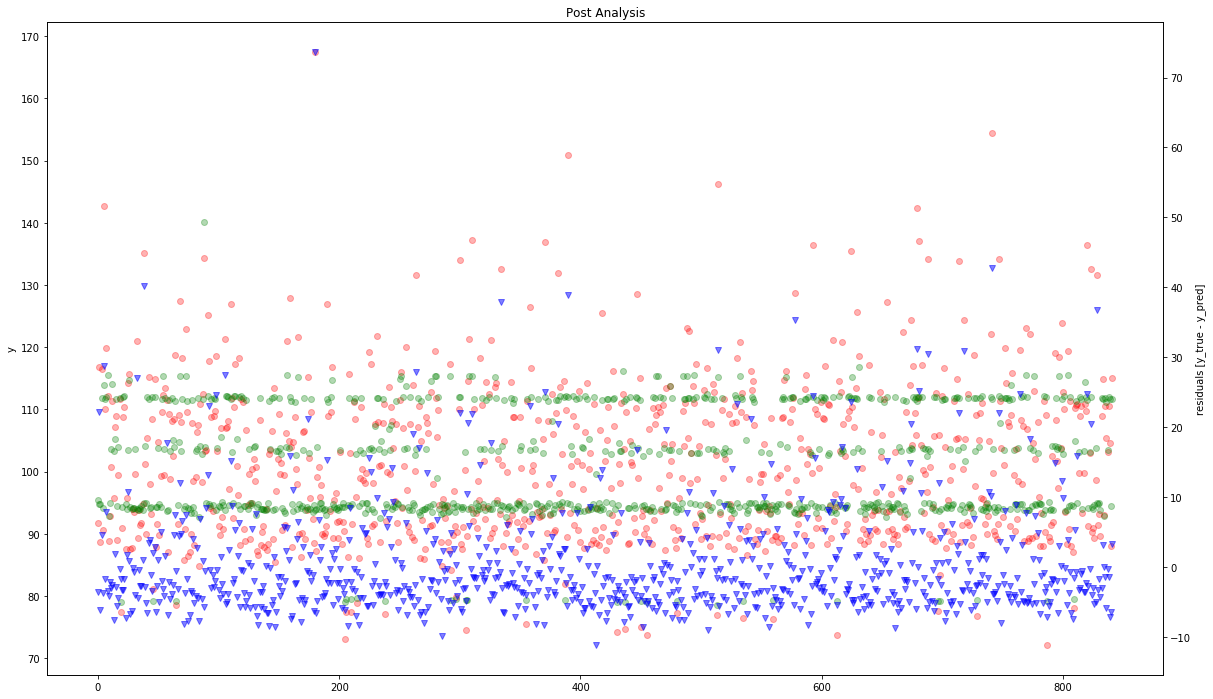

In [70]:
#post_analysis = val_x.copy()
post_analysis = pd.DataFrame()
post_analysis['y_pred'] = holdout_Y_ensembled
post_analysis['y_true'] = holdout_Y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

# graphing code
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
#ax1.plot(range(len(stacked_Y)), stacked_Y,'yo', alpha=0.30)

ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

In [71]:
# Create submission file
submission_df = test_df[['ID']]
submission_df['y'] = test_Y_ensemble_1.tolist()
submission_df.to_csv(os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'), index=False)
print('Generated submission ', os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'))

Generated submission  /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-1498406062.csv


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
